In [37]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
le=LabelEncoder()
df=pd.read_csv("Telco-Customer-Churn.csv")
cols = df.columns.tolist()
#Exclude invalid inputs in TotalCharges
df["TotalCharges"]=pd.to_numeric(df["TotalCharges"],errors='coerce')
df=df.dropna()
# Label encoding categorical features
for col in cols:
    if df[col].dtypes=="object":
        df[col]=le.fit_transform(df[col])
df.dtypes

customerID            int32
gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges        float64
Churn                 int32
dtype: object

## 1. Plot KDE for all 3 numerical features.

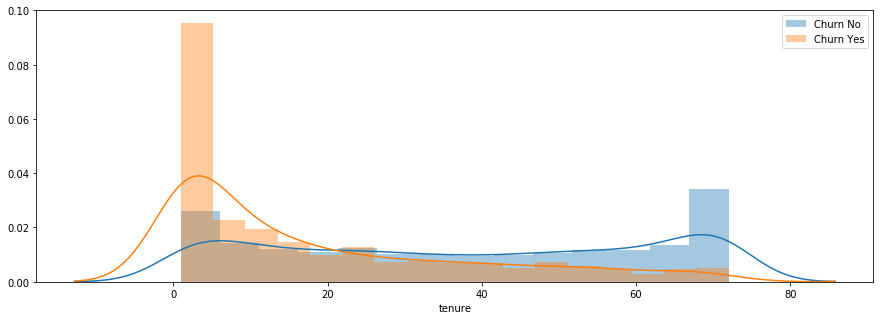

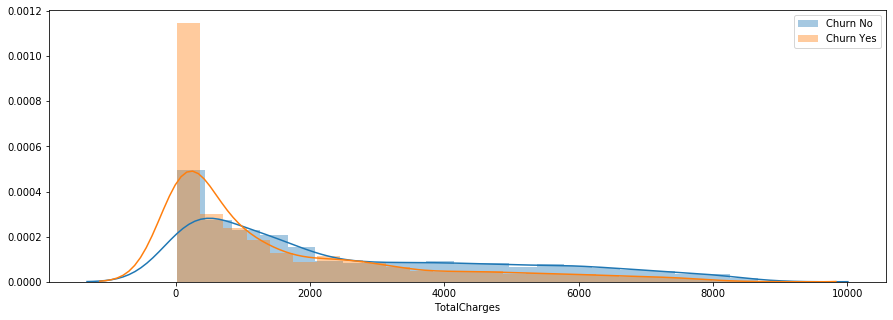

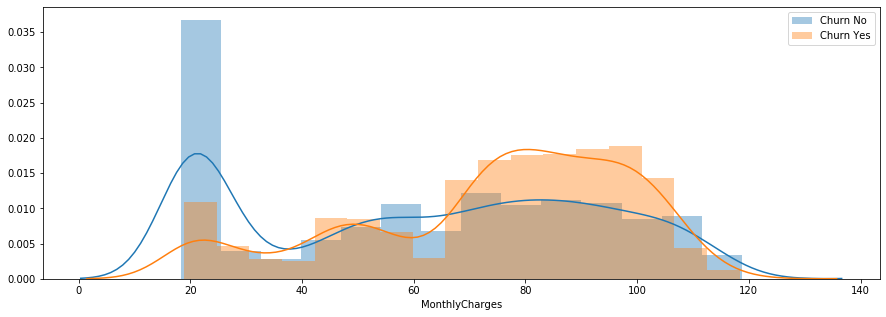

In [38]:
import matplotlib.pyplot as plt
def distplot(feature):    
    plt.figure(figsize=(15,5))
    sns.distplot(df[df["Churn"]==0][feature],label="Churn No")
    sns.distplot(df[df["Churn"]==1][feature],label="Churn Yes")
    plt.legend()
    plt.show()
distplot("tenure")
distplot("TotalCharges")
distplot("MonthlyCharges")

## 2. Countplot for all categorical features against churn. Results indicate that ~50% of the features bear strong correlation with churn in at least one class.

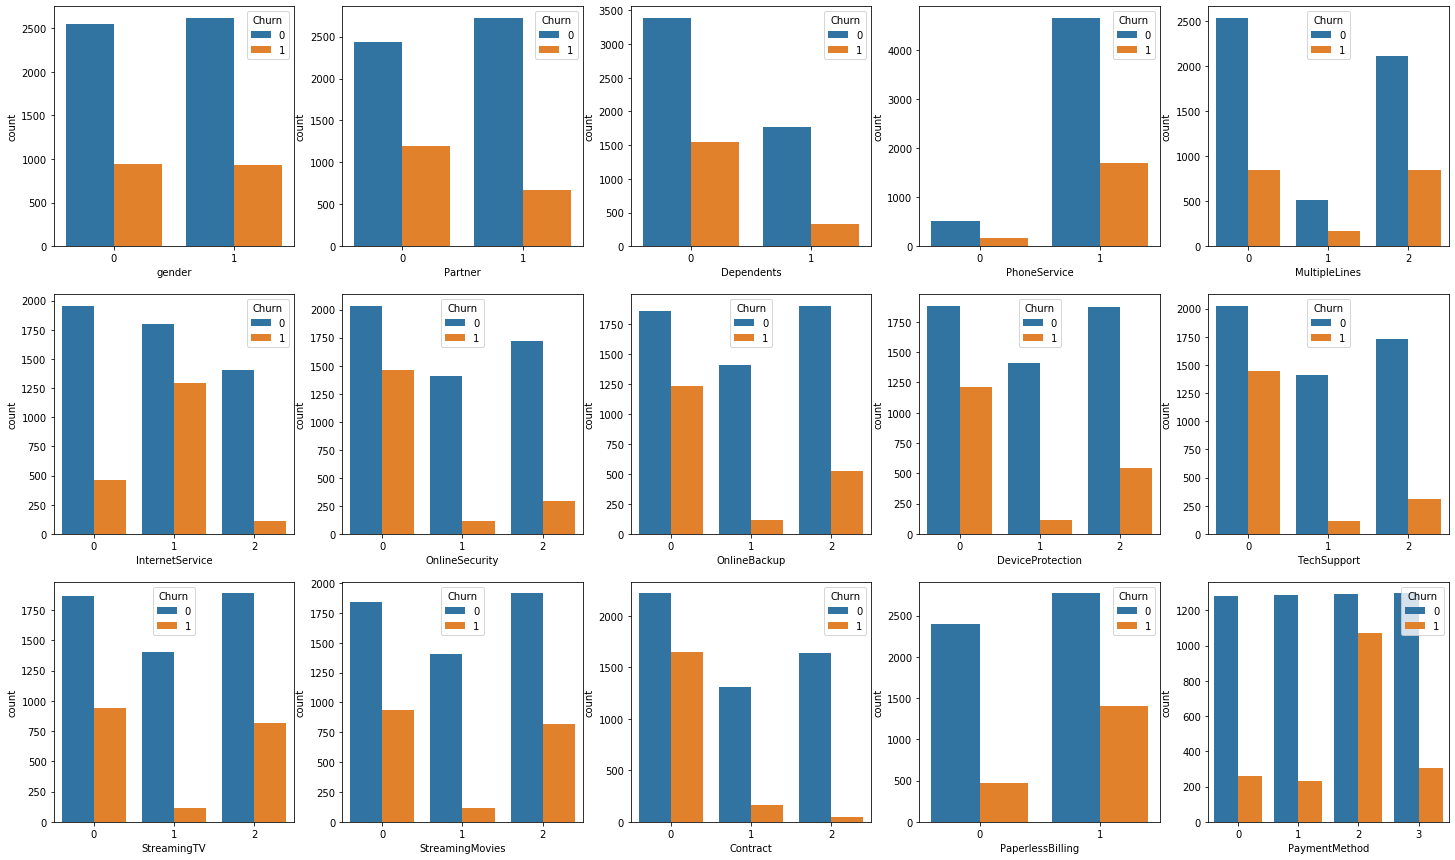

In [39]:
fig, axes = plt.subplots(3,5,figsize = (25,15))
sns.countplot(x = "gender", hue="Churn", data = df, ax=axes[0][0])
sns.countplot(x = "Partner", hue="Churn", data = df, ax=axes[0][1])
sns.countplot(x = "Dependents", hue="Churn", data = df, ax=axes[0][2])
sns.countplot(x = "PhoneService", hue="Churn", data = df, ax=axes[0][3])
sns.countplot(x = "MultipleLines", hue="Churn", data = df, ax=axes[0][4])
sns.countplot(x = "InternetService", hue="Churn", data = df, ax=axes[1][0])
sns.countplot(x = "OnlineSecurity", hue="Churn", data = df, ax=axes[1][1])
sns.countplot(x = "OnlineBackup", hue="Churn", data = df, ax=axes[1][2])
sns.countplot(x = "DeviceProtection", hue="Churn", data = df, ax=axes[1][3])
sns.countplot(x = "TechSupport", hue="Churn", data = df, ax=axes[1][4])
sns.countplot(x = "StreamingTV", hue="Churn", data = df, ax=axes[2][0])
sns.countplot(x = "StreamingMovies", hue="Churn", data = df, ax=axes[2][1])
sns.countplot(x = "Contract", hue="Churn", data = df, ax=axes[2][2])
sns.countplot(x = "PaperlessBilling", hue="Churn", data = df, ax=axes[2][3])
ax = sns.countplot(x = "PaymentMethod", hue="Churn",data = df, ax=axes[2][4])
plt.show(fig)

## 3. Correlation heatmap across all features to check colinearity. Results suggest that contract, MonthlyCharges, TotalCharges and tenure bear strong correlation with one another. It makes sense to some degree as TotalCharges is kinda determined by tenure.

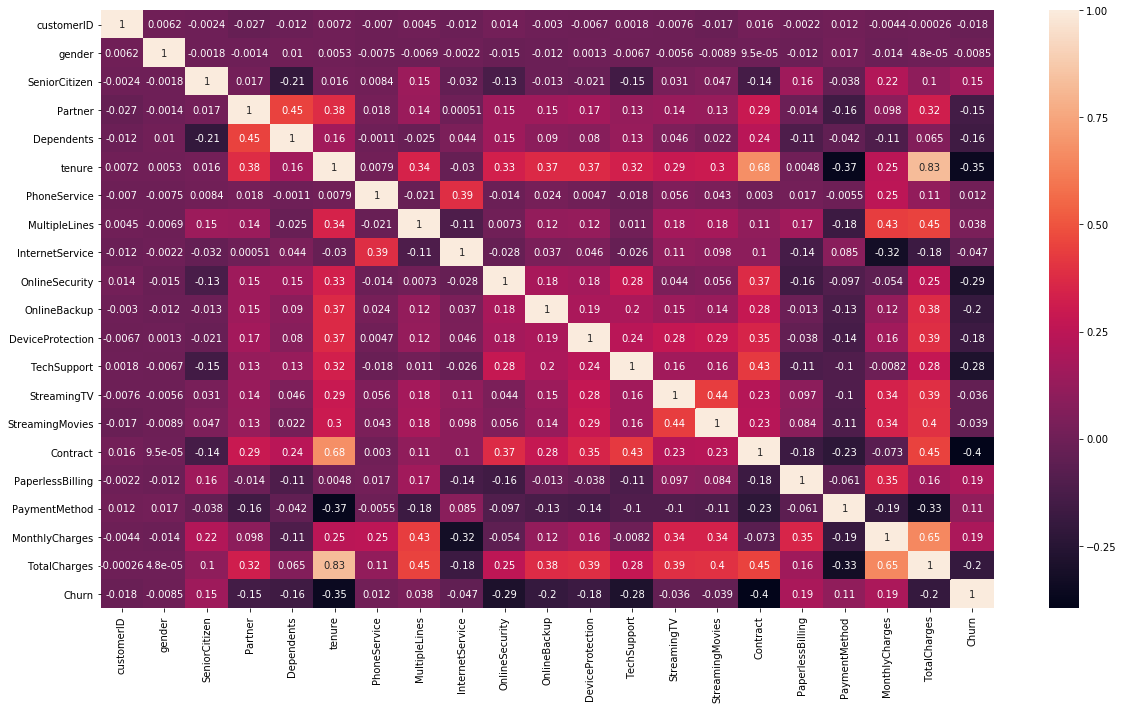

In [40]:
plt.figure(figsize=(20,11))
sns.heatmap(df.corr(),annot=True)

## 4. It is highly recommended to normalise MonthlyCharges and TotalCharges as sigmoid function is less sensitive to large inputs if logistic regression is used. 

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in ["MonthlyCharges","TotalCharges"]:
    df[col]=scaler.fit_transform(df[col].values.reshape(-1,1))
df[["MonthlyCharges","TotalCharges"]].head()

,MonthlyCharges,TotalCharges
0,0.115423,0.001275
1,0.385075,0.215867
2,0.354229,0.010310
3,0.239303,0.210241
4,0.521891,0.015330


## 5. Import packages and split train / test.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier

X = df.iloc[:,1:-1]
y = df["Churn"]
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.8)

## Random Forest

In [43]:
randomforest=RandomForestClassifier()
parms={'n_estimators':[20,40,60,80,100],
     'min_samples_leaf':[5,10,20,30,40]}
RF=GridSearchCV(randomforest,param_grid=parms,cv=StratifiedKFold(5))
RF.fit(x_train,y_train)
print('Random Forest best score:',RF.best_score_)

Random Forest best score: 0.8030222222222223


## XGBoost

In [55]:
xgboost = XGBClassifier()
parms= {'nthread':[4],
              'learning_rate': [0.05],
              'verbosity':[0],
              'max_depth': [6],
              'n_estimators': [20,40,60,80,100]}
XGB=GridSearchCV(xgboost,param_grid=parms,cv=StratifiedKFold(5))
XGB.fit(x_train,y_train)
print('XGBoost best score:',XGB.best_score_)

XGBoost best score: 0.8008888888888889


## Logistic Regression

In [45]:
logit = LogisticRegression()
parms= {}
LR=GridSearchCV(logit,param_grid=parms,cv=StratifiedKFold(5))
LR.fit(x_train,y_train)
print('XGBoost best score:',LR.best_score_)

XGBoost best score: 0.8019555555555555


## 6. Enlist scores for all 3 models. Results indicate that the performance across different models is very similar.

In [46]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,plot_roc_curve
results=[]
models=[RF,XGB,LR]
for model in models:
    y_predict=model.predict(x_test)
    ac=accuracy_score(y_test,y_predict)
    pc=precision_score(y_test,y_predict)
    rc=recall_score(y_test,y_predict)
    f1=f1_score(y_test,y_predict)
    results.append([ac,pc,rc,f1])
results_df = pd.DataFrame(results,columns=["Accuracy","Precision","Recall","F1"],index=["RF","XGB","LR"])
results_df

,Accuracy,Precision,Recall,F1
RF,0.803127,0.644068,0.524862,0.578387
XGB,0.804549,0.640777,0.546961,0.590164
LR,0.801706,0.627692,0.563536,0.593886


## 7. AUC-ROC plots for 3 different models. Again, they are alike.

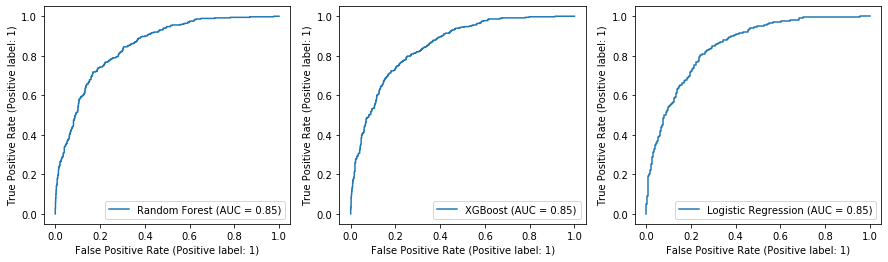

In [56]:
fig,axes=plt.subplots(1,3,figsize=(15,4))
names=["Random Forest","XGBoost","Logistic Regression"]
for i,j in enumerate(models):
    plot_roc_curve(j,x_test,y_test,ax=axes[i],name=names[i])
plt.show()